# Header Code

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import discrete

import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns

from IPython.core.display import HTML
HTML("<style>.container {width:50% !important; }</style>");

C:\Users\nolefp\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
# pandas options plus some more
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")
sns.set_context("poster")

In [6]:
# Matplotlib Formatting
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker


millnames = ['',' Thousand',' Million',' Billion',' Trillion']
def millify(n, pos):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    thingtoreturn = n / 10**(3 * millidx)
    if thingtoreturn % 1 == 0:
        return '{:.0f}{}'.format(thingtoreturn, millnames[millidx])
    elif thingtoreturn % 0.1 == 0:
        return '{:.1f}{}'.format(thingtoreturn, millnames[millidx])
    else:
        return '{:.2f}{}'.format(thingtoreturn, millnames[millidx])

# Coding and Classification Labels

**Municipal Codes**

In [7]:
municipal_codes_df = pd.read_excel("./General Info/Municipal Code Matching.xlsx")

In [8]:
municipal_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 2 columns):
mun_id    174 non-null int64
mun       174 non-null object
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


**Income Classification**

In [9]:
income_breakdown = pd.read_csv("./Budgets/income_breakdown.csv")

In [10]:
income_breakdown.head()

,l2,l2_name,l2_name_english,l3,l3_name,l3_name_english,l4,l4_name,l4_name_english,l6,l6_name,l6_name_english
0,"5,001.00",TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,Current income and income from sale of non-fin...,"5,002.00",TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,Current income,"5,003.00",POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...,Taxes,5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...","Taxes on income, profits and capital gains"
1,"5,129.00",PRIMANjA OD ZADUZIVANjA I PRODAJE FINANSIJSKE ...,Revenue from debt and sale of financial assets,"5,104.00",PRIMANjA OD PRODAJE NEFINANSIJSKE IMOVINE (510...,Income from the sale of non-financial assets,"5,047.00",SOCIJALNI DOPRINOSI (5048 + 5053),Social contributions,5008,POREZ NA FOND ZARADA (5009),Taxes on payroll and workforce
2,nan,NaN,NaN,"5,130.00",PRIMANjA OD ZADUZIVANjA (5131 + 5141),Income from borrowing,"5,057.00",DONACIJE I TRANSFERI (5058 + 5061 + 5064),Donations and transfers,5010,POREZ NA IMOVINU (od 5011 do 5016),Taxes on property
3,nan,NaN,NaN,"5,149.00",PRIMANjA OD PRODAJE FINANSIJSKE IMOVINE (5150 ...,Income from the sale of financial assets,"5,067.00",DRUGI PRIHODI (5068 + 5075 + 5080 + 5087 + 5090),Other income,5017,POREZ NA DOBRA I USLUGE (od 5018 do 5022),Taxes on goods and services
4,nan,NaN,NaN,nan,NaN,NaN,"5,092.00",MEMORANDUMSKE STAVKE ZA REFUNDACIJU RASHODA (5...,Memorandum items for the refunding of expendit...,5023,POREZ NA MEDJUNARODNU TRGOVINU I TRANSAKCIJE (...,Taxes on international trade and transactions


In [11]:
income_breakdown.columns

Index([u'l2', u'l2_name', u'l2_name_english', u'l3', u'l3_name', u'l3_name_english', u'l4', u'l4_name', u'l4_name_english', u'l6', u'l6_name', u'l6_name_english'], dtype='object')

In [12]:
codes_income =          [u'l2', u'l3', u'l4', u'l6']
names_income =          [u'l2_name', u'l3_name', u'l4_name', u'l6_name']
names_english_income =  [u'l2_name_english', u'l3_name_english', u'l4_name_english', u'l6_name_english']

for col in codes_income:
    income_breakdown[col] = income_breakdown[col].fillna(-1).astype(int)

# Pre-Processing'

**Overlapping Categories**

A significant amount of pre-procesessing was required here. The sums of four different levels of aggregation were included in the same table. As such, all revenues were counted at least four times. I disentangled the different categories, separated them into respective levels of aggregation, checked that the total sums matched at all levels of aggregation, and then reformatted the table so there would be no double counting. 

**Translation to English**

I translate to english first using google translate and then by cross-referencing IMF-s guide to public accounting statistics. I could not find exact matches for all categories, but I do my best. 



# Load and Set-up'

In [13]:
incomesdf = pd.read_csv("./Budgets/preprocessed_income.csv",dtype={"year": pd.datetime}, parse_dates=True)

**Sort Data Types**

In [14]:
print incomesdf.dtypes
print incomesdf.columns

mb           int64
mun_name    object
year        object
value       object
l6           int64
l6_name     object
l2           int64
l2_name     object
l3           int64
l3_name     object
l4           int64
l4_name     object
dtype: object
Index([u'mb', u'mun_name', u'year', u'value', u'l6', u'l6_name', u'l2', u'l2_name', u'l3', u'l3_name', u'l4', u'l4_name'], dtype='object')


In [15]:
# rename columns and change data types
for column in  [u'mun_name', "l6", u'l6_name', "l2", u'l2_name', "l3", u'l3_name', "l4", u'l4_name']:
    incomesdf[column] = incomesdf[column].astype('category')
    
incomesdf.columns = [u'mb', u'mun', u'year', u'income_value', u'l6', u'l6_name', 
                     u'l2', u'l2_name', u'l3', u'l3_name', u'l4', u'l4_name']

In [16]:
print incomesdf.dtypes
print incomesdf.columns

mb                 int64
mun             category
year              object
income_value      object
l6              category
l6_name         category
l2              category
l2_name         category
l3              category
l3_name         category
l4              category
l4_name         category
dtype: object
Index([u'mb', u'mun', u'year', u'income_value', u'l6', u'l6_name', u'l2', u'l2_name', u'l3', u'l3_name', u'l4', u'l4_name'], dtype='object')


In [17]:
incomesdf.year = incomesdf.year.str.replace("1/1/","")
incomesdf.year = incomesdf.year.astype(np.int32)

In [18]:
incomesdf.mb = incomesdf.mb.astype(np.int32)
incomesdf.income_value = incomesdf.income_value.str.replace(",","").astype(np.float64)

In [19]:
incomesdf.head(7)

,mb,mun,year,income_value,l6,l6_name,l2,l2_name,l3,l3_name,l4,l4_name
0,80012,Ada,2011,"165,821.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
1,80012,Ada,2012,"242,514.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
2,80012,Ada,2013,"226,214.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
3,70017,Aleksandrovac,2011,"138,120.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
4,70017,Aleksandrovac,2012,"193,121.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
5,70017,Aleksandrovac,2013,"196,794.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
6,70025,Aleksinac,2012,"403,067.00",5004,"POREZ NA DOHODAK, DOBIT I KAPITALNE DOBITKE (o...",5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...


**Summarize and Check for Odd/Missing Values**

In [20]:
incomesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15660 entries, 0 to 15659
Data columns (total 12 columns):
mb              15660 non-null int32
mun             15660 non-null category
year            15660 non-null int32
income_value    15660 non-null float64
l6              15660 non-null category
l6_name         15660 non-null category
l2              15660 non-null category
l2_name         15660 non-null category
l3              15660 non-null category
l3_name         15660 non-null category
l4              15660 non-null category
l4_name         15660 non-null category
dtypes: category(9), float64(1), int32(2)
memory usage: 399.7 KB


In [21]:
incomesdf.describe(include=["number"])

,mb,year,income_value
count,"15,660.00","15,660.00","15,660.00"
mean,"73,963.74","2,012.00","48,643.87"
std,"4,621.96",0.82,"620,453.40"
min,"70,017.00","2,011.00",-967.00
25%,"70,599.00","2,011.00",0.00
50%,"71,013.00","2,012.00",0.00
75%,"80,101.00","2,013.00","5,189.00"
max,"89,010.00","2,013.00","41,792,121.00"


In [22]:
incomesdf.describe(include=["category"])

,mun,l6,l6_name,l2,l2_name,l3,l3_name,l4,l4_name
count,15660,15660,15660,15660,15660,15660,15660,15660,15660
unique,145,36,36,2,2,4,4,15,15
top,coka,5160,TRANSFERI OD DRUGIH NIVOA VLASTI (5065 + 5066),5001,TEKUCI PRIHODI I PRIMANjA OD PRODAJE NEFINANSI...,5002,TEKUCI PRIHODI (5003 + 5047 + 5057 + 5067 + 50...,5003,POREZI (5004 + 5008 + 5010 + 5017 + 5023 + 503...
freq,108,435,435,13920,13920,9570,9570,3480,3480


**Add English Classification Names**

In [23]:
#incomesdf.head()

In [24]:
#income_breakdown.dtypes

In [25]:
# append english income classification names
for key, english_name in zip(codes_income, names_english_income):
    incomesdf = incomesdf.merge(income_breakdown[[key, english_name]] , how="left", on=key) 

In [26]:
incomesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15659
Data columns (total 16 columns):
mb                 15660 non-null int32
mun                15660 non-null object
year               15660 non-null int32
income_value       15660 non-null float64
l6                 15660 non-null int64
l6_name            15660 non-null object
l2                 15660 non-null int64
l2_name            15660 non-null object
l3                 15660 non-null int64
l3_name            15660 non-null object
l4                 15660 non-null int64
l4_name            15660 non-null object
l2_name_english    15660 non-null object
l3_name_english    15660 non-null object
l4_name_english    15660 non-null object
l6_name_english    15660 non-null object
dtypes: float64(1), int32(2), int64(4), object(9)
memory usage: 1.9+ MB


In [27]:
# change categorical data
for column in (names_english_income + names_income + ["mun", "year"]):
    incomesdf[column] = incomesdf[column].astype('category')

In [28]:
incomesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15659
Data columns (total 16 columns):
mb                 15660 non-null int32
mun                15660 non-null category
year               15660 non-null category
income_value       15660 non-null float64
l6                 15660 non-null int64
l6_name            15660 non-null category
l2                 15660 non-null int64
l2_name            15660 non-null category
l3                 15660 non-null int64
l3_name            15660 non-null category
l4                 15660 non-null int64
l4_name            15660 non-null category
l2_name_english    15660 non-null category
l3_name_english    15660 non-null category
l4_name_english    15660 non-null category
l6_name_english    15660 non-null category
dtypes: category(10), float64(1), int32(1), int64(4)
memory usage: 965.5 KB


** Remove Serbian Names** 

In [29]:
incomesdf.drop(['l6_name', u'l2_name', u'l3_name', u'l4_name'], axis=1, inplace=1)
incomesdf.columns = [u'mun_id', u'mun', u'year', u'income_value', u'l6', u'l2', u'l3', u'l4', 
                     u'l2_name_english', u'l3_name_english', u'l4_name_english', u'l6_name_english']

**Multiply Values by 10 so values are now in 100s of Serbian Dinars**

In [30]:
incomesdf.income_value = incomesdf.income_value * 10

# Basic EDA'

**Average Income From 2011-2013**

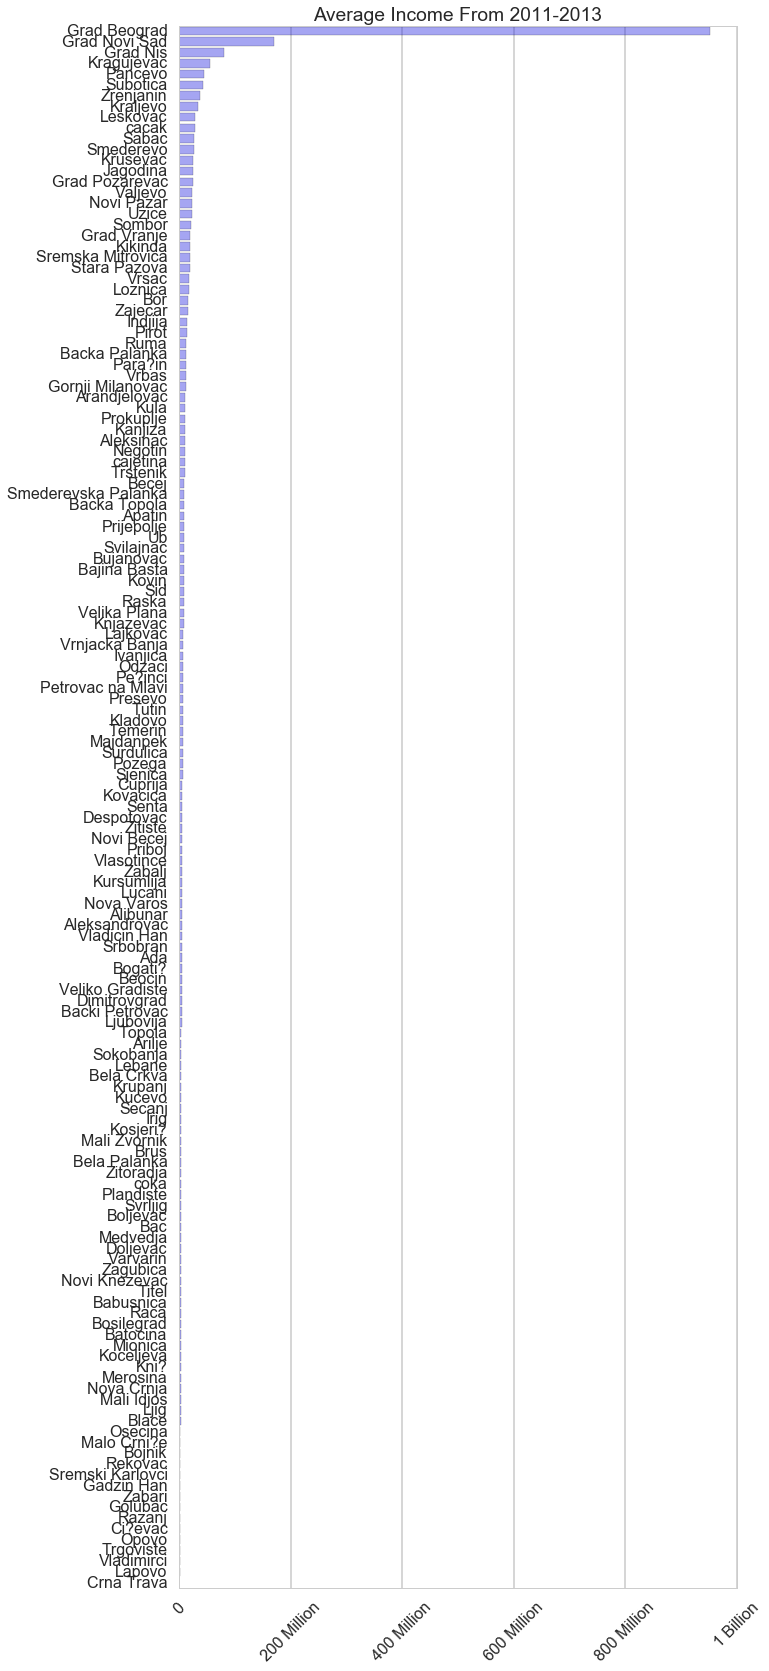

In [31]:
# chart 
fig, ax = plt.subplots(figsize=(10,28))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millify))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);
  

data = incomesdf.groupby(["mun","year"]).income_value.sum().mean(level=0)
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1* math.pow(10,9)))
plt.title("Average Income From 2011-2013");

**Breakdown of Total Income** - skewed by bigger municipalities

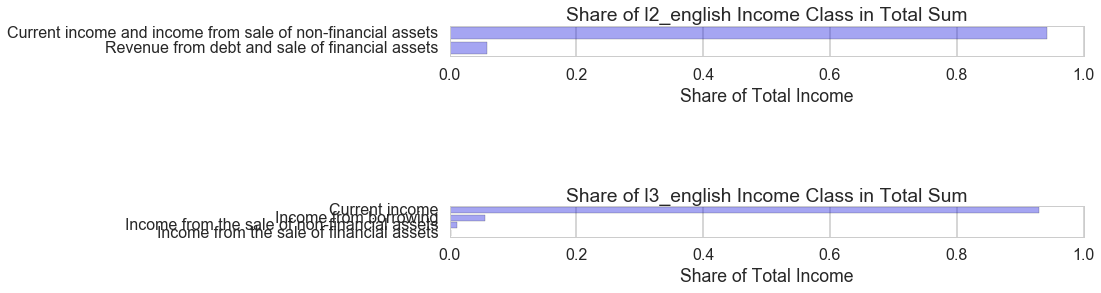

In [32]:
# multiple plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,4))
fig.tight_layout(h_pad=6.0)

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);   

#list of classes over which to iterate graphs
classes = ["l2_name_english", "l3_name_english"]

# make subplots
for ax, income_class in zip(axes.ravel(), classes): 
    
    # manipulate data in proper format
    data = incomesdf.groupby(income_class).income_value.agg(sum) / incomesdf.groupby(income_class).income_value.agg(sum).sum()
    data.sort_values(inplace=1, ascending=0)
    x = np.array(data.index)
    y = np.array(data.values)

    sns.barplot(y,x, color='blue', ax=ax, alpha=.4)
    

    ax.set_xlabel("Share of Total Income")
    ax.set_title("Share of " + income_class.replace("_name","") +" Income Class in Total Sum");

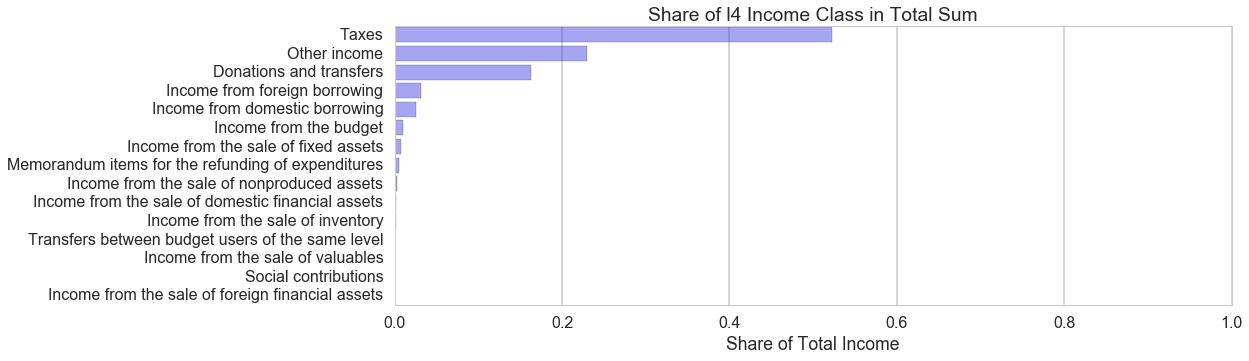

In [33]:
# chart
plt.figure(figsize=(15,5))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);   

data = (incomesdf.groupby("l4_name_english").income_value.agg(sum) / 
        incomesdf.groupby("l4_name_english").income_value.agg(sum).sum())
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1))
plt.xlabel("Share of Total Income")
plt.title("Share of l4 Income Class in Total Sum");

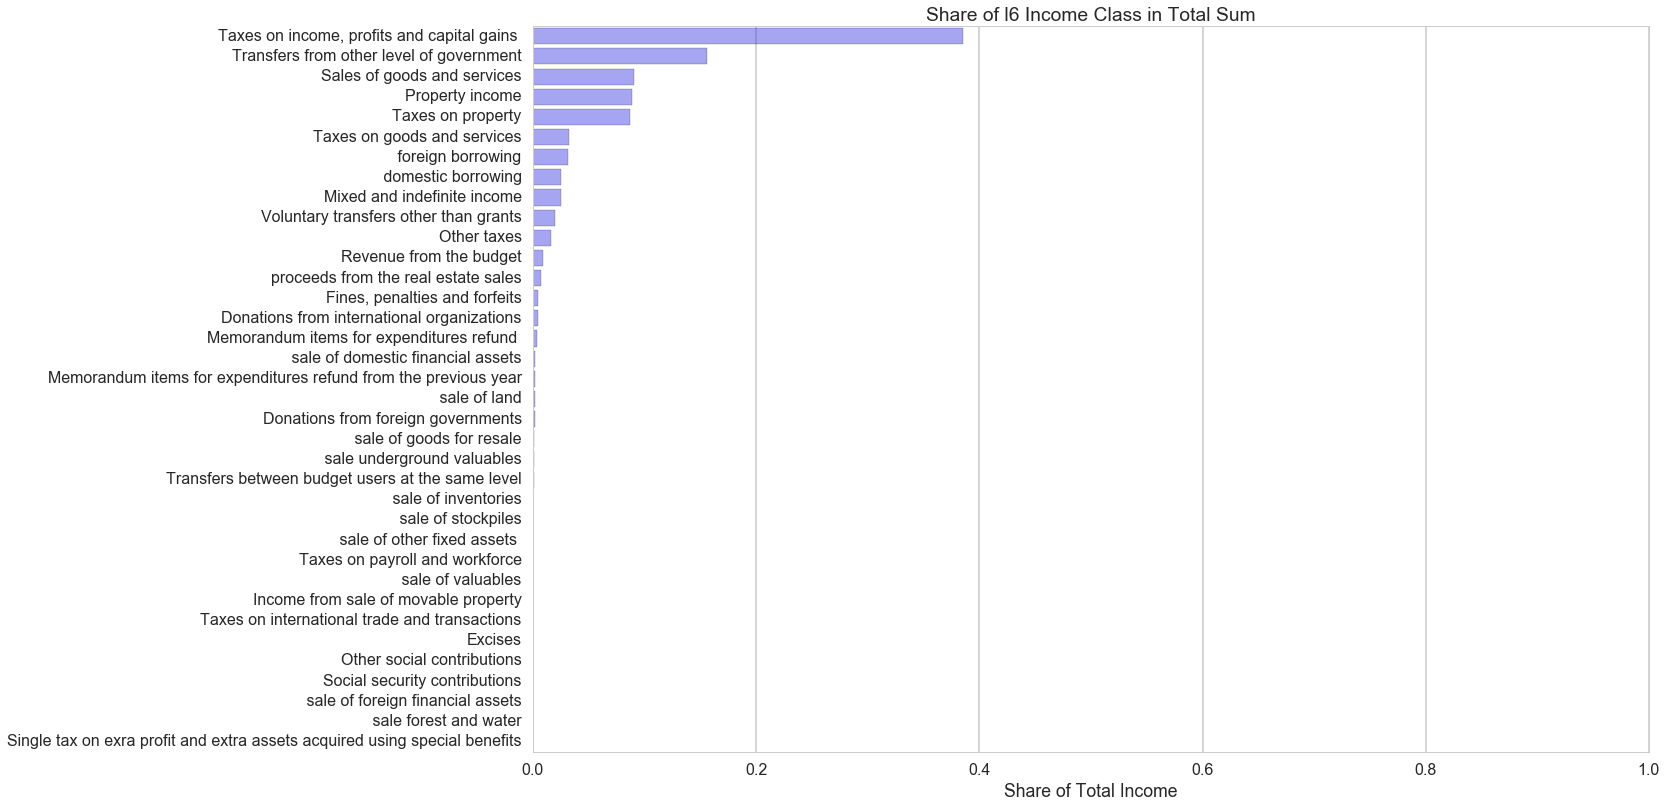

In [34]:
# chart
plt.figure(figsize=(20,13))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);   

data = (incomesdf.groupby("l6_name_english").income_value.agg(sum) 
        / incomesdf.groupby("l6_name_english").income_value.agg(sum).sum())
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1))
plt.xlabel("Share of Total Income")
plt.title("Share of l6 Income Class in Total Sum");

Comments:
- as one might expect, taxes on income and capgains provide the largest source of income for municipalities in Serbia
- transfers from other levels of government come in second place, with less than half overall contribution 

** Average Income Breakdown of Municipality ** - i.e. skewed by municipalities with extreme distributions of income sources

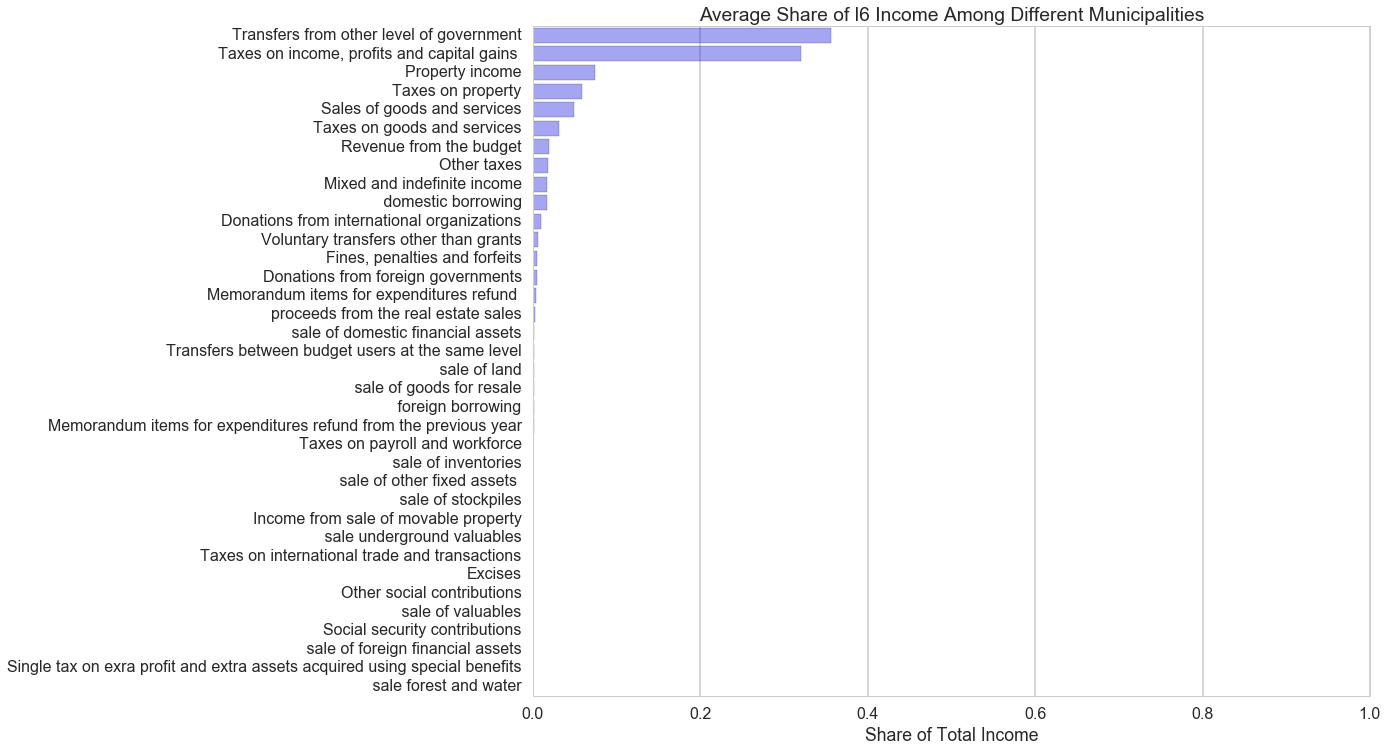

In [35]:
# chart
plt.figure(figsize=(15,12))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);   

data = ((incomesdf.groupby(["mun", "l6_name_english"]).income_value.sum() / 
         incomesdf.groupby(["mun", "l6_name_english"]).income_value.sum().sum(axis=0, level=0)).mean(axis=0, level=1))
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1))
plt.xlabel("Share of Total Income")
plt.title("Average Share of l6 Income Among Different Municipalities");

Comments:
- note, when the average of the shares across different municipalities is taken, there is a ***reversal between the top two spots*** and trasnfers become more important that taxes and direct sources of income! This indicates that it is the larger municipalities, or municipalities with more income overall which have a greater share of their revenue derived from their taxes. 

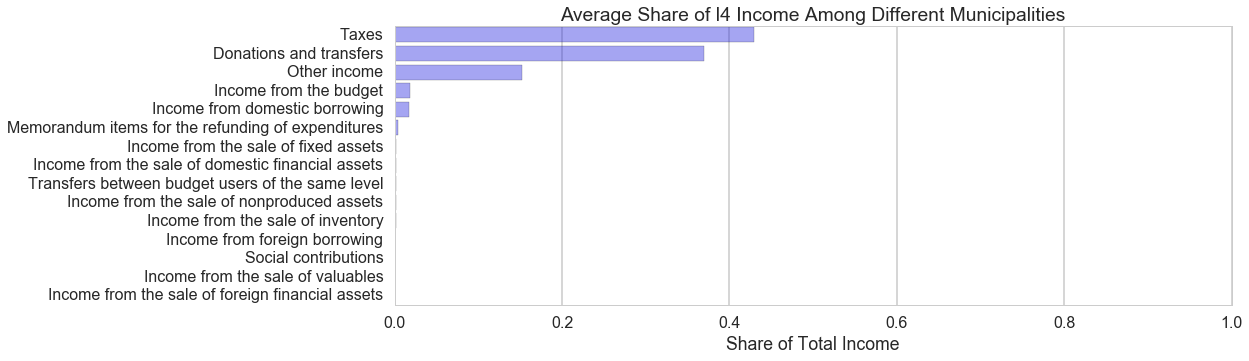

In [36]:
# chart
plt.figure(figsize=(15,5))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);   

data = (incomesdf.groupby(["mun", "l4_name_english"]).income_value.sum() / 
        incomesdf.groupby(["mun", "l4_name_english"]).income_value.sum().sum(axis=0, level=0)).mean(axis=0, level=1)
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1))
plt.xlabel("Share of Total Income")
plt.title("Average Share of l4 Income Among Different Municipalities");

Comments:
- while there is no reversal here, the difference between the overall tax category and overall donatios and transfers category is much less drastic, they are close to equal!

**Which Municipalities Have Largest Share of Income from Transfers and Donations?**

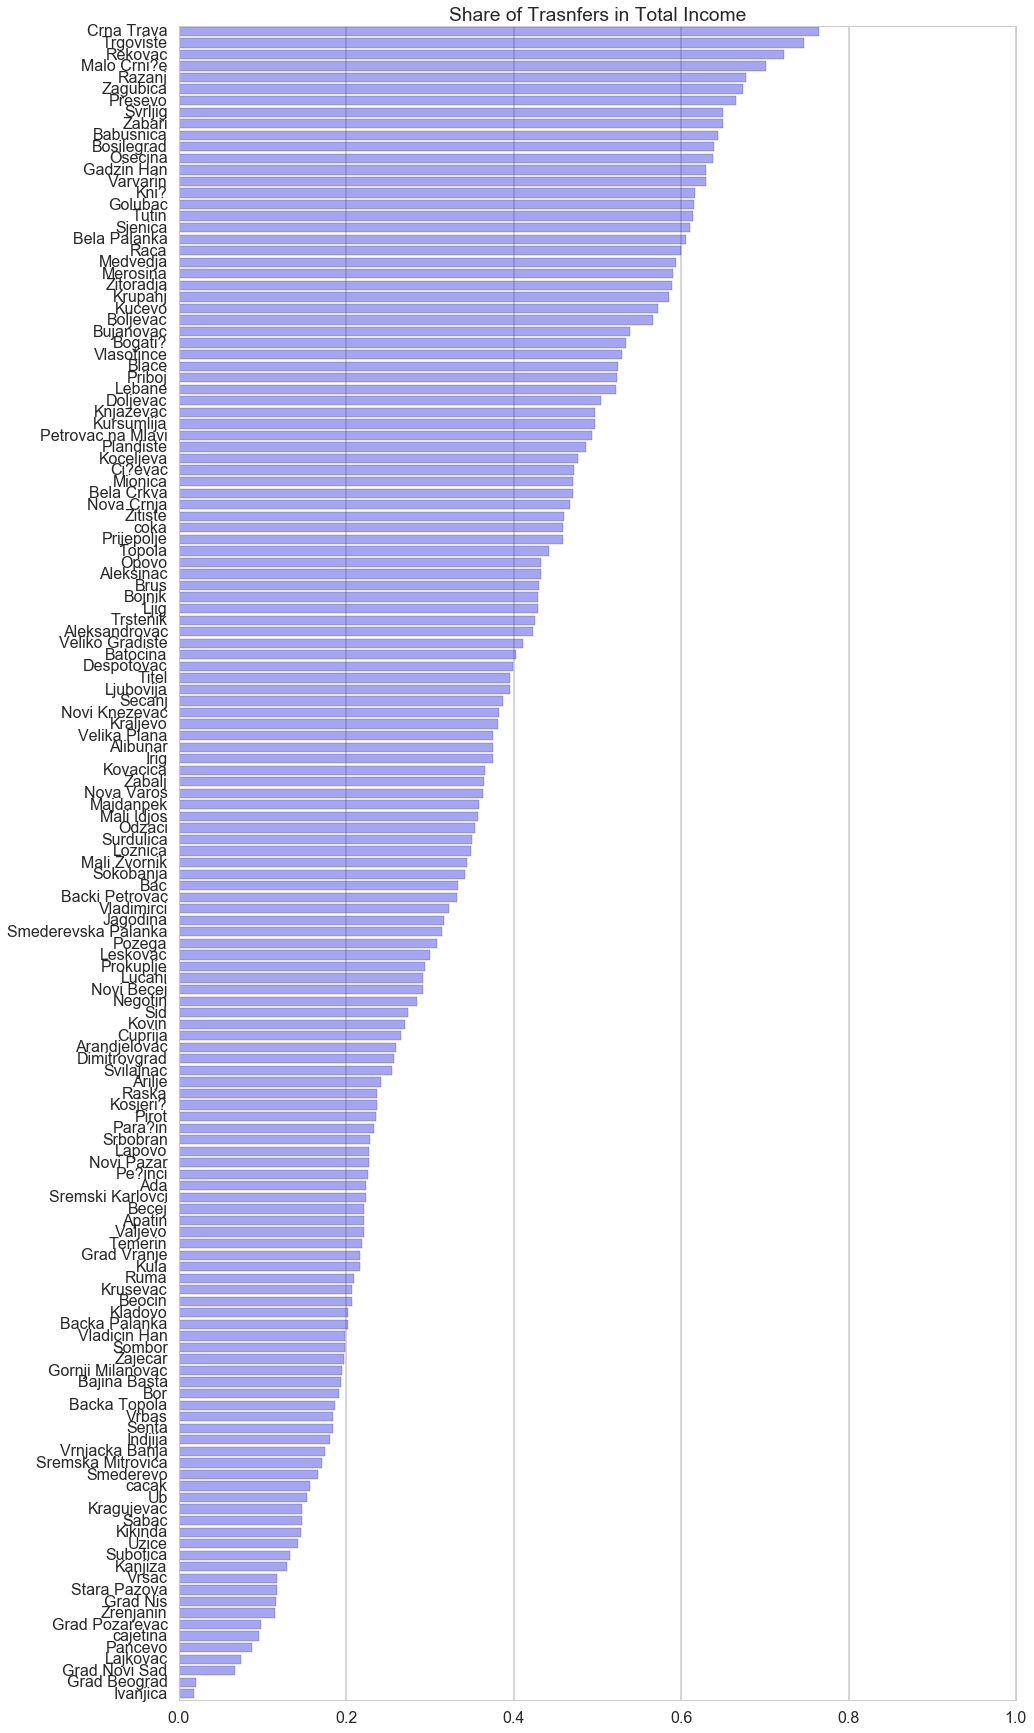

In [37]:
# chart
plt.figure(figsize=(15,30))
   

data = incomesdf[incomesdf["l6"] == 5064].groupby("mun").income_value.sum() / incomesdf.groupby("mun").income_value.sum()
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.xlim((0,1))
plt.title("Share of Trasnfers in Total Income");

In [38]:
# describe distribution of above
(incomesdf[incomesdf["l6"] == 5064].groupby("mun").income_value.sum() / incomesdf.groupby("mun").income_value.sum()).describe()

count   145.00
mean      0.36
std       0.18
min       0.02
25%       0.21
50%       0.34
75%       0.49
max       0.76
Name: income_value, dtype: float64

Comments:
- it makes sense that for more wealthy municipalities such as belgrade, the share which transfers from the national government play in their total income is much smaller
- it is a bit surprising that Ivanjica is in the smaller end of the transfer share, almost to the extent where it might be an anomaly...

Below, we examine average absolute levels of trasnfers to municipalities.

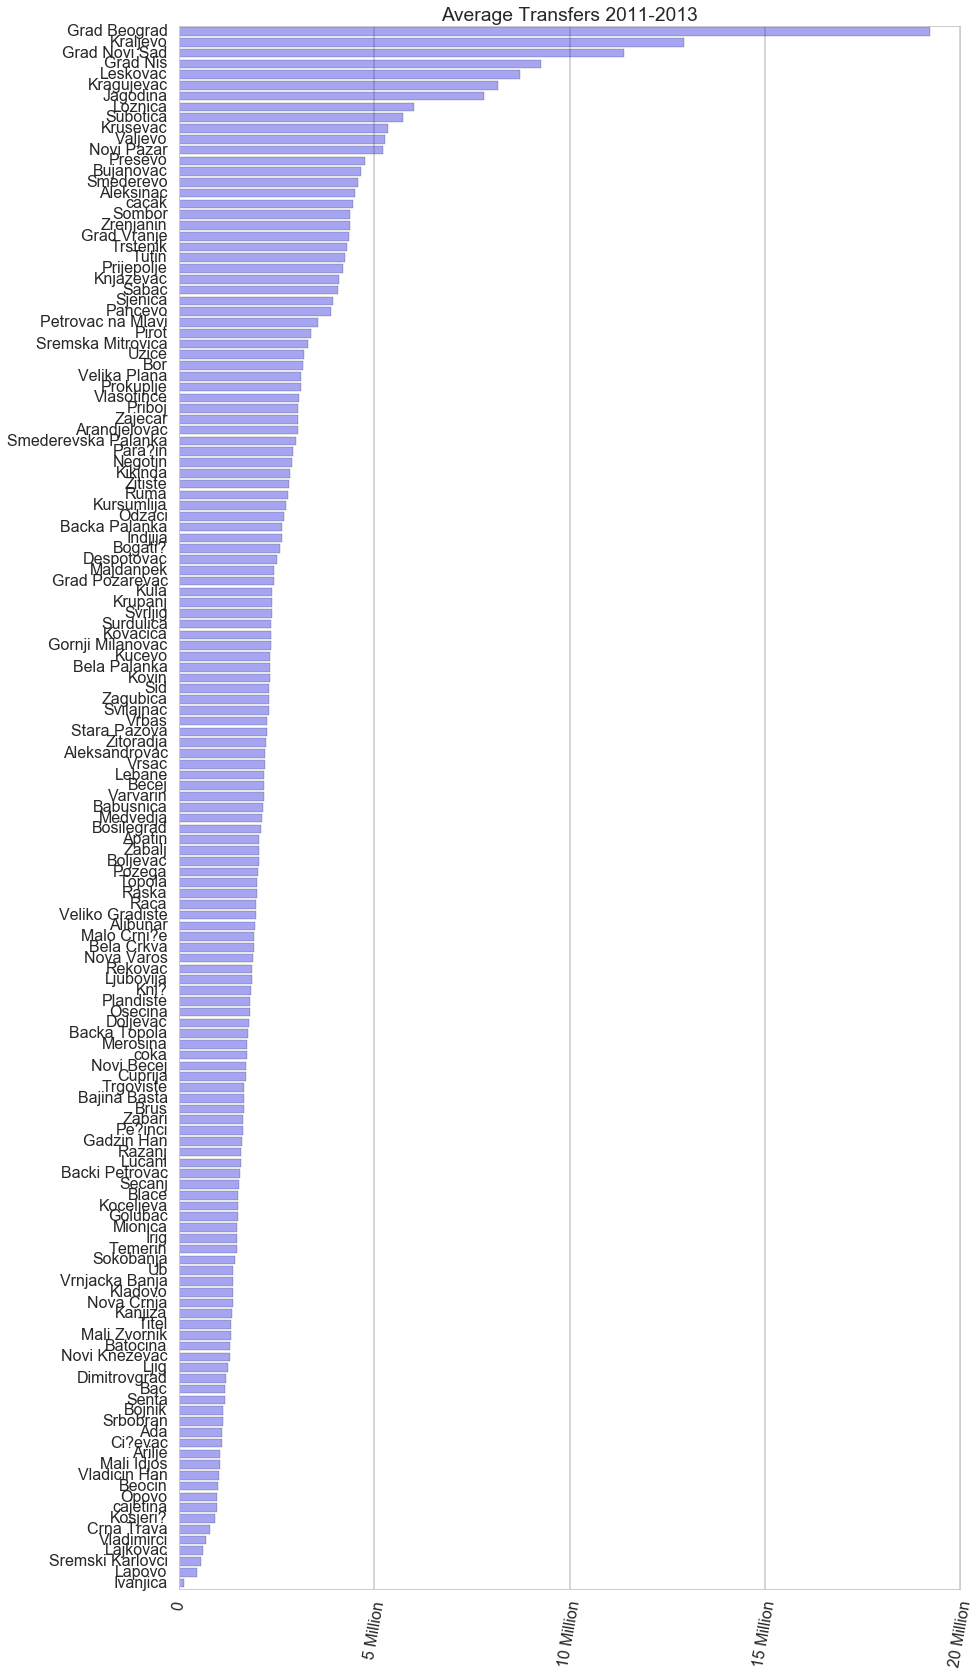

In [39]:
# chart 
fig, ax = plt.subplots(figsize=(14,28))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millify))

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=80);   

data = incomesdf[incomesdf["l6"] == 5064].copy().groupby(["mun","year"]).income_value.sum().mean(level="mun")
data.sort_values(inplace=1, ascending=0)
x = np.array(data.index)
y = np.array(data.values)

sns.barplot(y,x, color='blue', alpha=.4)

plt.title("Average Transfers 2011-2013");

In [40]:
incomesdf[incomesdf["l6"] == 5064].copy().groupby(["mun","year"]).income_value.sum()["Grad Beograd"]

year
2011   52,889,350.00
2012            0.00
2013    4,802,020.00
Name: income_value, dtype: float64

* Well, that doesn't seem right... 

# Export incomesdf

In [233]:
incomesdf.to_csv("./exports/incomesdf.csv")

# Connect National Budget

## Load nondisc13

In [239]:
# load file
nondisc13 = pd.read_excel("./national budget/transfers_from_state.xlsx", "2013_cleaned")

# change column names
nondisc13.columns = ["mun_id", "mun", "nondisc_general", "nondisc_solidarity", "nondisc_total"]

# convert columns to ints
for col in nondisc13.columns:
    if not re.search("mun", col):
        nondisc13[col] = nondisc13[col].str.replace(".","").fillna(0)
        nondisc13[col] = nondisc13[col].astype(float)

In [240]:
# get road spending 2013
nondisc13_roads = pd.read_excel("./national budget/transfers_from_state.xlsx", "corrected13_roads_cleaned")

# change column names
nondisc13_roads.columns = ["mun_id", "mun", "nondisc_roads"]

# convert columns to ints
for col in nondisc13_roads.columns:
    if not re.search("mun", col):
        nondisc13_roads[col] = nondisc13_roads[col].str.replace(".","").fillna(0)
        nondisc13_roads[col] = nondisc13_roads[col].astype(float)

In [241]:
# combine into final nondisc13
nondisc13 = nondisc13_roads[["mun_id", "nondisc_roads"]].merge(nondisc13, how="right", on="mun_id").fillna(0)
nondisc13.set_index("mun_id", inplace=1)

** fix road data**

In [242]:
road_to_fix = pd.read_excel("./national budget/transfers_from_state.xlsx", "copied")

In [243]:
x = road_to_fix[0::4].reset_index()
y = road_to_fix[1::4].reset_index()
z = road_to_fix[2::4].reset_index()
c = road_to_fix[3::4].reset_index()
roads_new = pd.concat([x,y,z,c], axis=1, ignore_index=True)

roads_new.drop(list(set(roads_new.columns)-set([4,10])), inplace=1,axis=1)
roads_new.to_excel("./national budget/corrected_roads.xlsx")

# Load reported transfers

In [244]:
# load self reported and get trasnfers from 2013
subset = incomesdf[(incomesdf.l6_name_english == 'Transfers from other level of government') & (incomesdf.year == 2013)] 

# transform data appropriately
grpdsub = subset.groupby(["mun_id","year"]).income_value.sum().reset_index().drop("year", axis=1).set_index("mun_id")

# combine with other dataset
nondisc13["self_transfers"] = grpdsub * 100
nondisc13["nondisc_total_roads"] = nondisc13.nondisc_roads + nondisc13.nondisc_total
nondisc13["discretionary_transfers"] = nondisc13["self_transfers"] - nondisc13["nondisc_total_roads"] 
nondisc13["discretionary_transfers_plus_roads"] = nondisc13["self_transfers"] - nondisc13["nondisc_total"] 

## Load political data

In [245]:
# load data
apaneldf = pd.read_csv("./exports/apaneldf.csv")

# get 2013 subset to merge
subs = apaneldf[apaneldf.date == "2013-01-01"].drop(["Unnamed: 0", "date"], axis=1).set_index("mun_id").drop("mun",axis=1)
discretionary13 = nondisc13.merge(subs, left_index=1, right_index=1)
discretionary13.to_csv("./exports/descretionary13.csv")